## According to our discussion , we have several ways to handle the missing data
First,using the function that I have created before,which using the the average to fill up the missing.  
Second,using the one Pengzhi used before.  
Third, using the Machine learning, combining the prediction from PV watts,to get assumption of the missing data.  

In [1]:
#First, I pick one of the dataframes , which is complete
import pandas as pd
import matplotlib.pyplot as plt
#from figures.csv_figures import add_time_col
DBoccia = pd.read_excel('../Cleaned_data/AnchorageSolar_cleaned/16DBoccia_cleaned.xlsx')
DBoccia

# Transfer the time into Datatime format
#DBoccia_new = add_time_col(DBoccia)

# plot out the trend of the data
plt.figure(figsize=(10,5))
plt.plot(DBoccia['Energy'])
plt.xlabel("Date")
plt.ylabel("Energy")
plt.title("The production of the panel")
plt.show()

<Figure size 1000x500 with 1 Axes>

# So,in my opinion, we think we need to divide into three cases.
1. the missing data is at the peak production month  
2. the missing data is at the lowest production month  
3. the missing data is neither 1 nor 2 situation.  



### First case.

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


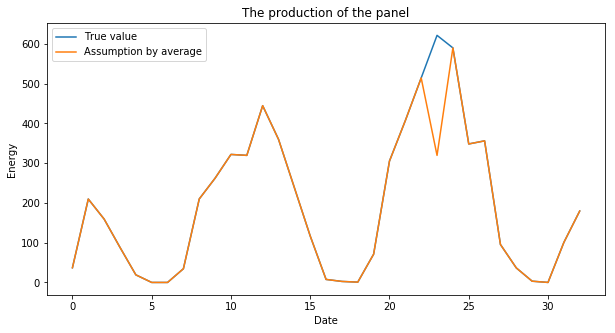

In [49]:
#So, let's try the first case.

#Drop the Seconde peak.
import numpy as np
DBoccia_with_missing = DBoccia.replace(DBoccia['Energy'][23],np.nan)

#(1).using the function 

# Create a function that will calculate the average of the same month in recent years
def filling_missing_data(dataframe):
    
    """The function will filled the missing point in a dataframe with the average of the same month in the recent
       years
       
       Args:
            dataframe(string):the name of the dataframe.
            
       Returns:
            A new dataframe
      """
    
    #get the index of the Missing data        
    index = dataframe['Energy'].index[dataframe['Energy'].apply(np.isnan)]
    dataframe_index = dataframe.index.values.tolist()
    a = [dataframe_index.index(i) for i in index]
    dataframe['Status']=""
    
    # extract the same months' data and calculate the average
    for i in a :
        Index_of_Month = []
        Energy_of_month=[]
        for n in range(len(dataframe)):
            if dataframe['Month'][n]==dataframe['Month'][i]:
                Index_of_Month.append(n)
        for c in Index_of_Month:
            Energy_of_month.append(dataframe['Energy'][c])
        average = np.nanmean(Energy_of_month)
        dataframe['Energy'][i] = average
        dataframe['Status'][i] = 0
      
    return(dataframe)

# filling the missing data with average
Dboccia_without_missing = filling_missing_data(DBoccia_with_missing)

plt.figure(figsize=(10,5))
plt.plot(DBoccia['Energy'],label='True value')
plt.plot(Dboccia_without_missing['Energy'],label='Assumption by average')
plt.xlabel("Date")
plt.ylabel("Energy")
plt.legend()
plt.title("The production of the panel")
plt.show()

#Apparently, the assumption is really bad.

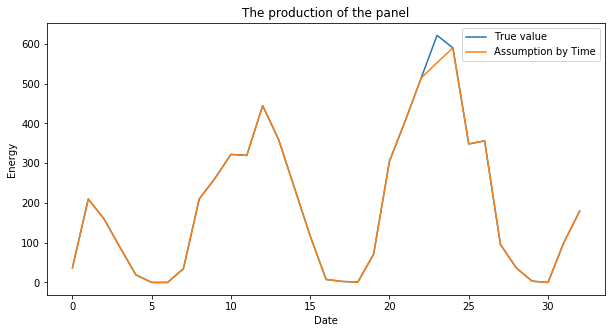

In [48]:
#(2).using the interpolate (Time)

#Drop the Seconde peak.
import numpy as np
from figures.csv_figures import add_time_col
DBoccia_with_missing = DBoccia.replace(DBoccia['Energy'][23],np.nan)

DBoccia_with_missing = add_time_col(DBoccia_with_missing)
DBoccia_with_missing.set_index('Date',inplace=True)

Dboccia_without_missing =DBoccia_with_missing.interpolate(method='time')
Dboccia_without_missing.reset_index(inplace=True)

plt.figure(figsize=(10,5))
plt.plot(DBoccia['Energy'],label='True value')
plt.plot(Dboccia_without_missing['Energy'],label='Assumption by Time')
plt.xlabel("Date")
plt.ylabel("Energy")
plt.legend()
plt.title("The production of the panel")
plt.show()

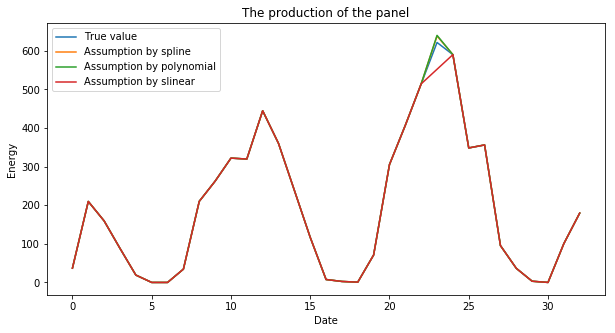

In [66]:
# using the interpolate (spline,polynomial,slinear)
import numpy as np
DBoccia_with_missing = DBoccia.replace(DBoccia['Energy'][23],np.nan)
DBoccia_with_missing.drop(['DC Capacity','Location'],axis=1,inplace=True)

Dboccia_without_missing_a =DBoccia_with_missing.interpolate(method='spline',order=3)
Dboccia_without_missing_b =DBoccia_with_missing.interpolate(method='polynomial',order=3)
Dboccia_without_missing_c =DBoccia_with_missing.interpolate(method='slinear')

# DBoccia_with_missing_d= add_time_col(DBoccia_with_missing)
# DBoccia_with_missing_d.set_index('Date',inplace=True)
# Dboccia_without_missing_d =DBoccia_with_missing.interpolate(method='time')
# Dboccia_without_missing_d.reset_index(inplace=True)

plt.figure(figsize=(10,5))
plt.plot(DBoccia['Energy'],label='True value')
plt.plot(Dboccia_without_missing_a['Energy'],label='Assumption by spline')
plt.plot(Dboccia_without_missing_b['Energy'],label='Assumption by polynomial')
plt.plot(Dboccia_without_missing_c['Energy'],label='Assumption by slinear')
# plt.plot(Dboccia_without_missing_d['Energy'],label='Assumption by Time')
plt.xlabel("Date")
plt.ylabel("Energy")
plt.legend()
plt.title("The production of the panel")
plt.show()

# The problem is that you change the order, the assumption will be different.

In [62]:
# using the machine learning combined with the PV watts.
#Drop the Seconde peak.
import numpy as np
from figures.csv_figures import add_time_col
import pandas as pd
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

DBoccia_with_missing = DBoccia.replace(DBoccia['Energy'][23],np.nan)
# DBoccia_with_missing = add_time_col(DBoccia_with_missing)
DBoccia_with_missing.drop(['DC Capacity','Location'],axis=1,inplace=True)
month_change = {'November':11,'December':12,'January': 1,
                'February':2,'March':3,'April':4,'May':5,
                'June':6,'July':7,'August':8,'September':9,'October':10}
DBoccia_with_missing['Month'] = DBoccia_with_missing['Month'].map(month_change)
DBoccia_without_missing = DBoccia_with_missing.dropna()

train_data_x = DBoccia_without_missing.iloc[:,:2]
train_data_y = DBoccia_without_missing.iloc[:,2]

logreg.fit(train_data_x,train_data_y)

test_data = DBoccia_with_missing.iloc[:,:2]
a = logreg.predict(test_data)
DBoccia['Predicted'] = a
# energy_predicted['Energy'] = pd.DataFrame(linreg.predict(test_data))
# DBoccia_with_missing.Energy.fillna(linreg.predict(test_data),inplace=True)

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Unknown label type: 'continuous'

In [108]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

DBoccia_with_missing = DBoccia.replace(DBoccia['Energy'][23],np.nan)
DBoccia_with_missing.drop(['DC Capacity','Location'],axis=1,inplace=True)
month_change = {'November':11,'December':12,'January': 1,
                'February':2,'March':3,'April':4,'May':5,
                'June':6,'July':7,'August':8,'September':9,'October':10}
DBoccia_with_missing['Month'] = DBoccia_with_missing['Month'].map(month_change)
DBoccia_without_missing = DBoccia_with_missing.dropna()
DBoccia_without_missing.reset_index(drop=True,inplace=True)

x_list=[]
for i in range(len(DBoccia_without_missing)):
    a = [DBoccia_without_missing['Year'][i],DBoccia_without_missing['Month'][i]]
    x_list.append(a)

y_list=[]
for i in range(len(DBoccia_without_missing)):
    b = DBoccia_without_missing['Energy'][i]
    y_list.append(b)
    
X_test=[]
for i in range(len(DBoccia_with_missing)):
    c = [DBoccia_with_missing['Year'][i],DBoccia_with_missing['Month'][i]]
    X_test.append(c)

poly = PolynomialFeatures(degree=8)
X_ = poly.fit_transform(x_list)
X_test_ = poly.fit_transform(X_test)

# Instantiate
lg = LinearRegression()

# Fit
lg.fit(X_, y_list)

# Obtain coefficients
lg.coef_

# Predict
a = lg.predict(X_test_)

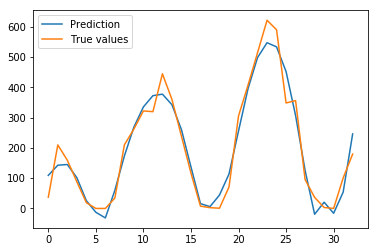

In [111]:
plt.plot(a,label='Prediction')
plt.plot(DBoccia['Energy'],label='True values')
plt.legend()

## Try to use these methods to handle some real missing data

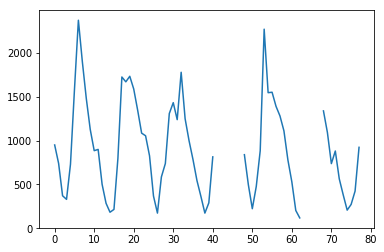

In [49]:
# import area
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import one file has real missing data
bethel = pd.read_excel('../Cleaned_data/RuralAk/RuralAK_Bethel_cleaned.xlsx')

#using plt to show if there is missing data
plt.plot(bethel['Energy'])

#So,there are plenty of missing data

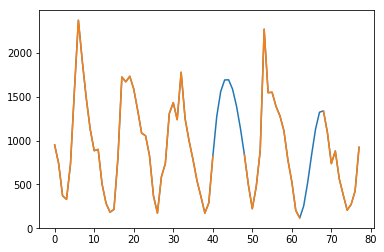

In [53]:
#So, since we have known that the average functions prediction is really bad. so we just using the next 2 ways

#First,using the interpolate

#drop two columns which may cause the errors
bethel_with_missing = bethel.drop(['DC Capacity','Location'],axis=1)
bethel_missing_filled = bethel_with_missing.interpolate(method='polynomial',order=3)

#plt
plt.plot(bethel_missing_filled['Energy'])
plt.plot(bethel['Energy'])

In [51]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

bethel = pd.read_excel('../Cleaned_data/RuralAk/RuralAK_Bethel_cleaned.xlsx')

bethel_with_missing = bethel.drop(['DC Capacity','Location'],axis=1)
month_change = {'November':11,'December':12,'January': 1,
                'February':2,'March':3,'April':4,'May':5,
                'June':6,'July':7,'August':8,'September':9,'October':10}
bethel_with_missing['Month'] = bethel_with_missing['Month'].map(month_change)
bethel_without_missing = bethel_with_missing.dropna()
bethel_without_missing.reset_index(drop=True,inplace=True)

x_list=[]
for i in range(len(bethel_without_missing)):
    a = [bethel_without_missing['Year'][i],bethel_without_missing['Month'][i]]
    x_list.append(a)

y_list=[]
for i in range(len(bethel_without_missing)):
    b = bethel_without_missing['Energy'][i]
    y_list.append(b)
    
X_test=[]
for i in range(len(bethel_with_missing)):
    c = [bethel_with_missing['Year'][i],bethel_with_missing['Month'][i]]
    X_test.append(c)

poly = PolynomialFeatures(degree=8)
X_ = poly.fit_transform(x_list)
X_test_ = poly.fit_transform(X_test)

# Instantiate
lg = LinearRegression()

# Fit
lg.fit(X_, y_list)

# Obtain coefficients
lg.coef_

# Predict
a = lg.predict(X_test_)

In [83]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

bethel = pd.read_excel('../Cleaned_data/RuralAk/RuralAK_Bethel_cleaned.xlsx')

bethel_with_missing = bethel.drop(['DC Capacity','Location'],axis=1)

list_of_missing = []
month_change = {'November':11,'December':12,'January': 1,
                'February':2,'March':3,'April':4,'May':5,
                'June':6,'July':7,'August':8,'September':9,'October':10}
bethel_with_missing['Month'] = bethel_with_missing['Month'].map(month_change)

for i in range(len(bethel_with_missing)):
    if np.isnan(bethel_with_missing['Energy'][i]) == True:
        year_month = [bethel_with_missing['Year'][i],bethel_with_missing['Month'][i]]
        list_of_missing.append(year_month)

bethel_without_missing = bethel_with_missing.dropna()
bethel_without_missing.reset_index(drop=True,inplace=True)

x_list=[]
for i in range(len(bethel_without_missing)):
    a = [bethel_without_missing['Year'][i],bethel_without_missing['Month'][i]]
    x_list.append(a)

y_list=[]
for i in range(len(bethel_without_missing)):
    b = bethel_without_missing['Energy'][i]
    y_list.append(b)
    
# X_test=[]
# for i in range(len(bethel_with_missing)):
#     c = [bethel_with_missing['Year'][i],bethel_with_missing['Month'][i]]
#     X_test.append(c)

poly = PolynomialFeatures(degree=8)
X_ = poly.fit_transform(x_list)
X_test_ = poly.fit_transform(list_of_missing)

# Instantiate
lg = LinearRegression()

# Fit
lg.fit(X_, y_list)

# Obtain coefficients
lg.coef_

# Predict
a = lg.predict(X_test_)

#fill with predicted
b = a.tolist()

In [84]:
index_of_missing=[]
for i in range(len(bethel_with_missing)):
    if np.isnan(bethel_with_missing['Energy'][i]) == True:
        index_of_missing.append(i)
fill = pd.DataFrame(index=index_of_missing,data=b,columns=['Energy'])
c = bethel.fillna(fill)

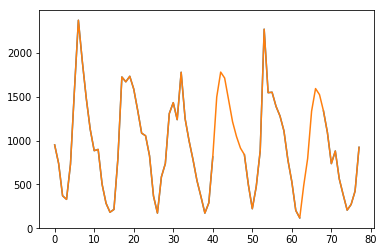

In [93]:
plt.plot(bethel['Energy'])
plt.plot(c['Energy'])